# Evaluación Cuantitativa de Explicabilidad con Quantus

Este notebook evalúa cuantitativamente la calidad de las explicaciones XAI usando la librería Quantus.

**Métricas evaluadas:**
- **Fidelidad (Faithfulness)**: Faithfulness Correlation - mide si la explicación refleja el comportamiento interno del modelo.
- **Robustez (Robustness)**: Average Sensitivity - evalúa la estabilidad ante perturbaciones leves.
- **Complejidad (Complexity)**: Entropy/Complexity - estima la simplicidad de la explicación.
- **Aleatorización (Randomization)**: Randomization Test - mide la dependencia respecto a la semilla.
- **Localización (Localization)**: Region Perturbation - determina la precisión espacial.

**Métodos XAI evaluados:**
- Grad-CAM
- Grad-CAM++
- Integrated Gradients
- Saliency Maps

**Nota:** Este notebook evalúa los 3 modelos individuales (`blood`, `retina`, `breast`) y genera gráficos radar comparativos a partir de los ficheros JSON producidos por `quantus_evaluation.py`.

Comprobación de GPU (ejecutado originalmente):

```python
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

```

In [30]:
import sys
print(sys.executable)

/root/miniconda3/envs/py3.10/bin/python


In [31]:
import sys, numpy as np
print(sys.executable)
print(np.__version__)

/root/miniconda3/envs/py3.10/bin/python
1.26.4


In [32]:
# Configuración inicial

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import pi

# Definir ruta absoluta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()

assert PROJECT_DIR.exists(), f"No existe el directorio del proyecto: {PROJECT_DIR}"

# Configuración de rutas
OUTPUTS_DIR = PROJECT_DIR / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)

# Lista de datasets que vamos a usar
datasets = ["blood", "retina", "breast"]

# Número de muestras evaluadas en Quantus por dataset
NUM_SAMPLES = 100  # Aumentar implica mayor tiempo de cómputo en quantus_evaluation.py

print(f"Directorio de outputs: {OUTPUTS_DIR}")
print(f"Muestras evaluadas por dataset (Quantus): {NUM_SAMPLES}")

Directorio de outputs: /home/TFM_Laura_Monne/outputs
Muestras evaluadas por dataset (Quantus): 100


In [33]:
# Carga de resultados Quantus para los 3 datasets

results_by_dataset = {}

for dataset in datasets:
    json_path = OUTPUTS_DIR / f"quantus_metrics_{dataset}.json"
    if json_path.exists():
        with open(json_path, "r") as f:
            results_by_dataset[dataset] = json.load(f)
        print(f"✅ Cargado: {dataset} ({json_path.name})")
    else:
        print(f"⚠️  No encontrado: {json_path.name}")
        print("   Ejecuta `python quantus_evaluation.py --dataset", dataset, "...` antes de usar este notebook.")

if not results_by_dataset:
    raise ValueError("❌ No se encontraron resultados Quantus. Genera primero los ficheros JSON con quantus_evaluation.py.")

✅ Cargado: blood (quantus_metrics_blood.json)
✅ Cargado: retina (quantus_metrics_retina.json)
✅ Cargado: breast (quantus_metrics_breast.json)


In [34]:
from math import pi

# Lista de datasets que vamos a usar (por claridad)
datasets = ["blood", "retina", "breast"]

# Métricas a mostrar en los radares
# Orden: Robustez (top), Fidelidad (right), Aleatorización, Localización (bottom), Complejidad (left)
metric_names = ["robustness", "faithfulness", "randomization", "localization", "complexity"]
metric_labels = ["Robustez", "Fidelidad", "Aleatorización", "Localización", "Complejidad"]

# Métodos XAI
methods = ["gradcam", "gradcampp", "integrated_gradients", "saliency"]
method_labels = {
    "gradcam": "Grad-CAM",
    "gradcampp": "Grad-CAM++",
    "integrated_gradients": "Integrated Gradients",
    "saliency": "Saliency",
}


In [35]:
def build_df_for_dataset(dataset_name: str) -> pd.DataFrame:
    """Devuelve un DataFrame con las métricas *originales* de Quantus
    para un dataset concreto ("blood" / "retina" / "breast").

    - Filas: métodos XAI
    - Columnas: métricas (faithfulness, robustness, complexity, randomization, localization)
    """
    results = results_by_dataset[dataset_name]

    data = {m: [] for m in methods}
    for m in methods:
        if m not in results:
            continue
        for metric in metric_names:
            info = results[m].get(metric, None)
            if info is None:
                data[m].append(np.nan)
            else:
                data[m].append(float(info["mean"]))

    df = pd.DataFrame.from_dict(data, orient="index", columns=metric_names)
    return df


In [ ]:
# NUEVO
def plot_radar_for_dataset(dataset_name: str):
    """Dibuja un gráfico radar para un dataset (blood/retina/breast),
    normalizando cada métrica entre los métodos XAI de ese dataset.
    """
    df = build_df_for_dataset(dataset_name)

    print(f"\n=== {dataset_name.upper()} - valores originales ===")
    display(df)

    # Normalización min–max mejorada por métrica dentro del dataset
    df_norm = df.copy()
    
    # Información diagnóstica sobre métricas constantes
    constant_metrics = []

    for metric in metric_names:
        col = df[metric].values.astype(float)
        # Filtrar NaN antes de calcular min/max
        valid_col = col[~np.isnan(col)]
        
        if len(valid_col) == 0:
            # Si todos los valores son NaN, asignar 0.5
            df_norm[metric] = 0.5
            constant_metrics.append(f"{metric} (todos NaN)")
        else:
            mn, mx = np.nanmin(col), np.nanmax(col)
            
            # Detectar si todos los valores son iguales (métrica constante)
            if mx - mn < 1e-8:
                # Si todos los métodos tienen el mismo valor en esa métrica
                df_norm[metric] = 0.5
                constant_metrics.append(f"{metric} (valor constante: {mn:.4f})")
            else:
                # Normalización min-max estándar
                # Para métricas con valores negativos (como faithfulness), esto funciona bien
                # ya que normaliza al rango [0, 1] preservando la relación relativa
                df_norm[metric] = (col - mn) / (mx - mn)
                # Reemplazar NaN resultantes con 0
                df_norm[metric] = df_norm[metric].fillna(0.0)
                
                # Para faithfulness con valores negativos, podríamos considerar normalizar
                # usando valores absolutos, pero la normalización min-max estándar
                # preserva mejor la información sobre correlaciones negativas

        # Invertimos las métricas donde "menos es mejor"
        # (robustness, complexity, randomization: valores más bajos son mejores)
        if metric in ["robustness", "complexity", "randomization"]:
            df_norm[metric] = 1.0 - df_norm[metric]
    
    # Mostrar advertencia si hay métricas constantes
    if constant_metrics:
        print(f"\n⚠️  ADVERTENCIA: Las siguientes métricas tienen valores constantes (normalizadas a 0.5):")
        for cm in constant_metrics:
            print(f"   - {cm}")
        print("   Esto puede indicar que la métrica no está diferenciando entre métodos XAI.")

    print(f"\n=== {dataset_name.upper()} - valores normalizados (0-1) ===")
    display(df_norm)

    # Ángulos del radar (DENTRO de la función)
    N = len(metric_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # cerrar círculo

    # Crear figura
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection="polar")

    # Poner el primer eje arriba y sentido horario
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Dejar espacio real para la leyenda a la derecha (sin usar tight_layout)
    fig.subplots_adjust(left=0.08, right=0.78, top=0.92, bottom=0.08)

    # Dibujar cada método
    for method in df_norm.index:
        vals = df_norm.loc[method, metric_names].tolist()
        vals = [0.0 if (v is None or (isinstance(v, (int, float)) and np.isnan(v))) else float(v) for v in vals]
        vals += vals[:1]

        ax.plot(angles, vals, linewidth=2, marker="o", label=method_labels.get(method, method))
        ax.fill(angles, vals, alpha=0.25)

    # Ejes y estética
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)

    ax.grid(True, linestyle="--", alpha=0.5)

    plt.title(
        f"Perfil de Métricas por Método XAI\nDataset: {dataset_name.upper()} (normalizado 0-1)",
        size=16,
        fontweight="bold",
        pad=30,
    )

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), fontsize=10, framealpha=0.9)

    out_path = OUTPUTS_DIR / f"quantus_radar_{dataset_name}.png"

    # IMPORTANTE: en polar, evitar bbox_inches="tight" para que no recorte raro
    plt.savefig(out_path, dpi=300, facecolor="white")
    print(f"✅ Figura guardada en: {out_path}")

    plt.show()
    plt.close()


In [39]:
def plot_radar_for_dataset(dataset_name: str):
    """Dibuja un gráfico radar para un dataset (blood/retina/breast),
    normalizando cada métrica entre los métodos XAI de ese dataset.
    """
    df = build_df_for_dataset(dataset_name)

    print(f"\n=== {dataset_name.upper()} - valores originales ===")
    display(df)

    # Normalización min–max por métrica dentro del dataset
    df_norm = df.copy()

    for metric in metric_names:
        col = df[metric].values.astype(float)
        # Filtrar NaN antes de calcular min/max
        valid_col = col[~np.isnan(col)]
        
        if len(valid_col) == 0:
            # Si todos los valores son NaN, asignar 0.5
            df_norm[metric] = 0.5
        else:
            mn, mx = np.nanmin(col), np.nanmax(col)
            
            if mx - mn < 1e-8:
                # Si todos los métodos tienen el mismo valor en esa métrica
                df_norm[metric] = 0.5
            else:
                df_norm[metric] = (col - mn) / (mx - mn)
                # Reemplazar NaN resultantes con 0
                df_norm[metric] = df_norm[metric].fillna(0.0)

        # Invertimos las métricas donde "menos es mejor"
        if metric in ["robustness", "complexity", "randomization"]:
            df_norm[metric] = 1.0 - df_norm[metric]

    print(f"\n=== {dataset_name.upper()} - valores normalizados (0-1) ===")
    display(df_norm)

    # Ángulos del radar
    # Rotar -90° para que la primera métrica (Robustez) esté arriba (top)
    # Esto hace que el orden sea: Robustez (top), Fidelidad (right), Aleatorización, 
    # Localización (bottom), Complejidad (left)
    N = len(metric_names)
    angles = [n / float(N) * 2 * pi - pi/2 for n in range(N)]  # Rotar -90° para empezar arriba
    angles += angles[:1]  # cerrar círculo

    # Crear figura con tamaño adecuado para gráficos polares
    # Los gráficos polares necesitan espacio extra para las etiquetas radiales
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(111, projection='polar')
    
    # Configurar márgenes generosos para que el gráfico polar se vea completo
    # Los gráficos polares necesitan espacio alrededor para las etiquetas
    plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05)

    # Dibujar cada método
    for method in df_norm.index:
        vals = df_norm.loc[method, metric_names].tolist()
        # Reemplazar NaN con 0 para visualización (evita problemas en el plot)
        vals = [0.0 if (isinstance(v, (int, float)) and np.isnan(v)) else (0.0 if v is None else float(v)) for v in vals]
        vals += vals[:1]  # cerrar círculo

        ax.plot(
            angles,
            vals,
            linewidth=2,
            marker="o",
            label=method_labels.get(method, method),
        )
        ax.fill(angles, vals, alpha=0.25)

    # Ejes y estética
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=9)

    ax.grid(True, linestyle="--", alpha=0.5)
    plt.title(
        f"Perfil de Métricas por Método XAI\nDataset: {dataset_name.upper()} (normalizado 0-1)",
        size=16,
        fontweight="bold",
        pad=30,
    )

    # Colocar la leyenda en una posición que no interfiera con el gráfico
    ax.legend(loc="upper left", bbox_to_anchor=(1.15, 1.0), fontsize=10, framealpha=0.9)
    
    # NO usar tight_layout para gráficos polares, puede recortar el gráfico
    # Los márgenes ya están configurados con subplots_adjust

    # Guardar figura con márgenes generosos
    out_path = OUTPUTS_DIR / f"quantus_radar_{dataset_name}.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor='white', pad_inches=0.5)
    print(f"✅ Figura guardada en: {out_path}")

    plt.show()
    plt.close()  # Cerrar la figura para liberar memoria



=== BLOOD - valores originales ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.020264,0.008895,1.0,0.276739,11.526514
gradcampp,0.012545,-0.003098,1.0,0.254500,11.648903
integrated_gradients,0.425010,0.189592,1.0,0.306706,11.235367
saliency,0.356204,-0.043130,1.0,0.467551,11.145209



=== BLOOD - valores normalizados (0-1) ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.981286,0.223548,0.5,0.104385,0.242982
gradcampp,1.000000,0.172015,0.5,0.000000,0.000000
integrated_gradients,0.000000,1.000000,0.5,0.245041,0.821006
saliency,0.166817,0.000000,0.5,1.000000,1.000000


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_blood.png


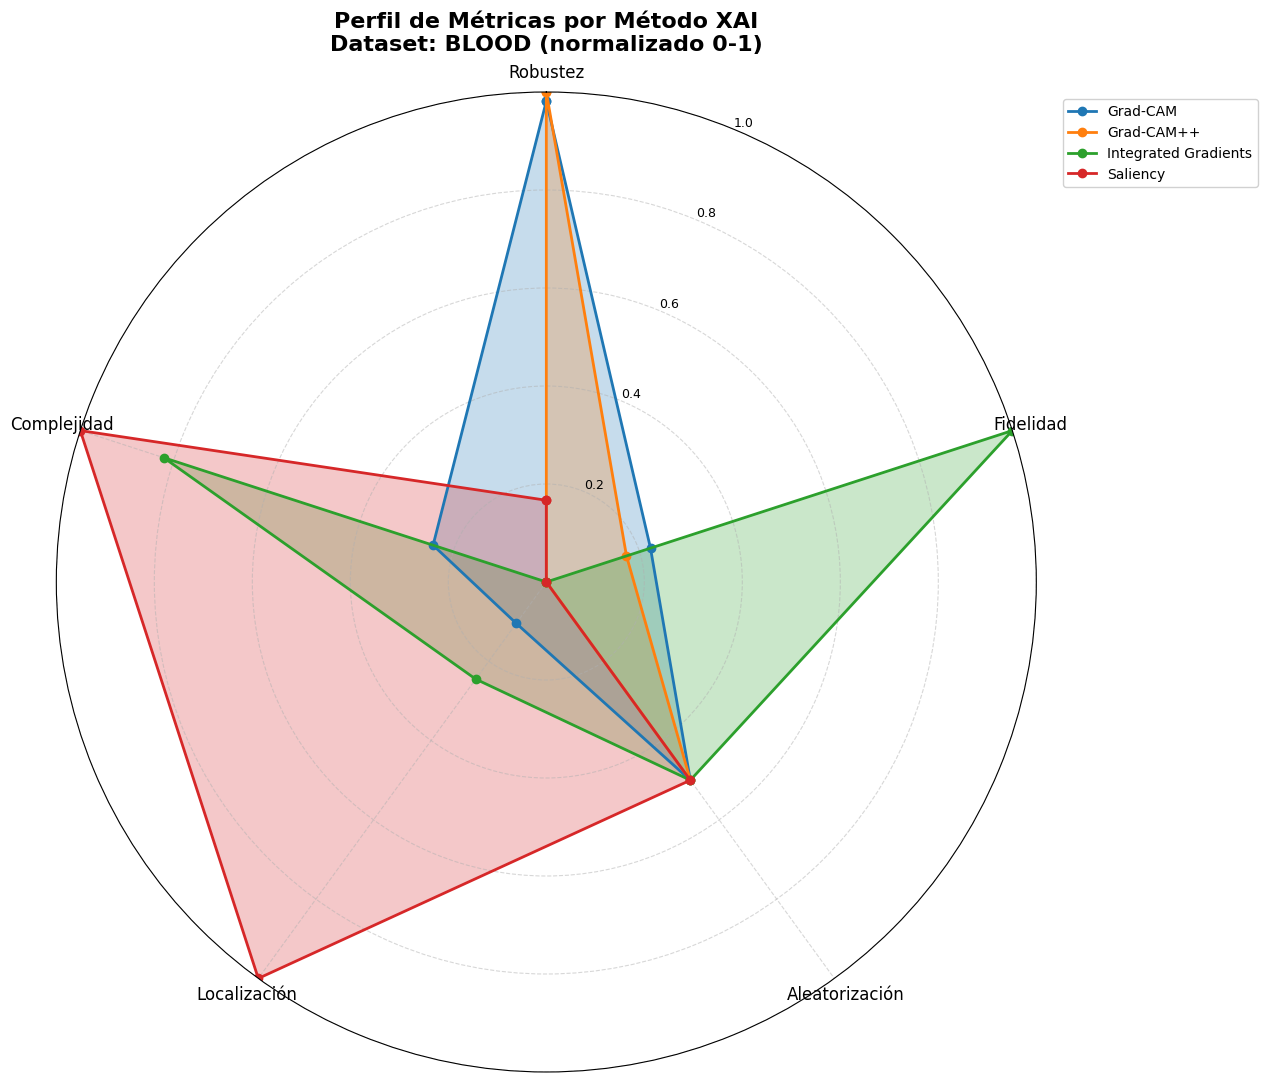


=== RETINA - valores originales ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.090986,-0.082678,1.0,0.009325,11.470676
gradcampp,0.063984,-0.077665,1.0,0.009963,11.624961
integrated_gradients,0.580300,-0.102741,1.0,0.042530,11.087545
saliency,0.544347,0.042085,1.0,-0.005767,10.934252



=== RETINA - valores normalizados (0-1) ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.947704,0.138530,0.5,0.312479,0.223372
gradcampp,1.000000,0.173147,0.5,0.325688,0.000000
integrated_gradients,0.000000,0.000000,0.5,1.000000,0.778064
saliency,0.069634,1.000000,0.5,0.000000,1.000000


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_retina.png


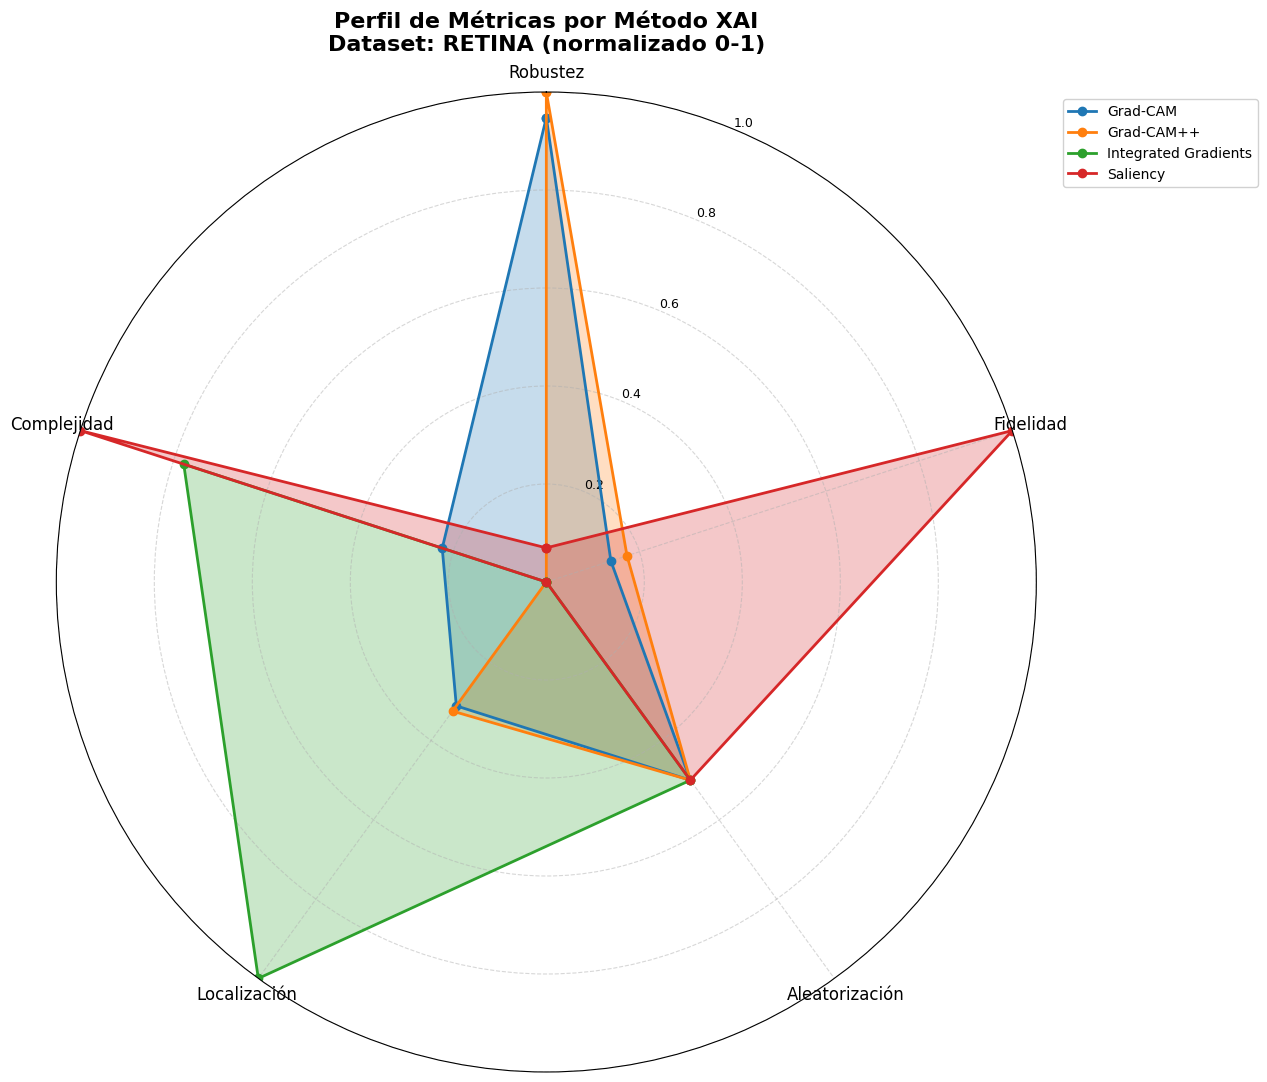


=== BREAST - valores originales ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.095278,-0.014878,1.0,0.062674,11.578883
gradcampp,0.079342,-0.019664,1.0,0.082613,11.698756
integrated_gradients,0.776031,-0.127031,1.0,0.079096,11.163041
saliency,0.659700,-0.076906,1.0,0.119530,11.196381



=== BREAST - valores normalizados (0-1) ===


,robustness,faithfulness,randomization,localization,complexity
gradcam,0.977126,1.000000,0.5,0.000000,0.223764
gradcampp,1.000000,0.957323,0.5,0.350685,0.000000
integrated_gradients,0.000000,0.000000,0.5,0.288840,1.000000
saliency,0.166977,0.446936,0.5,1.000000,0.937765


✅ Figura guardada en: /home/TFM_Laura_Monne/outputs/quantus_radar_breast.png


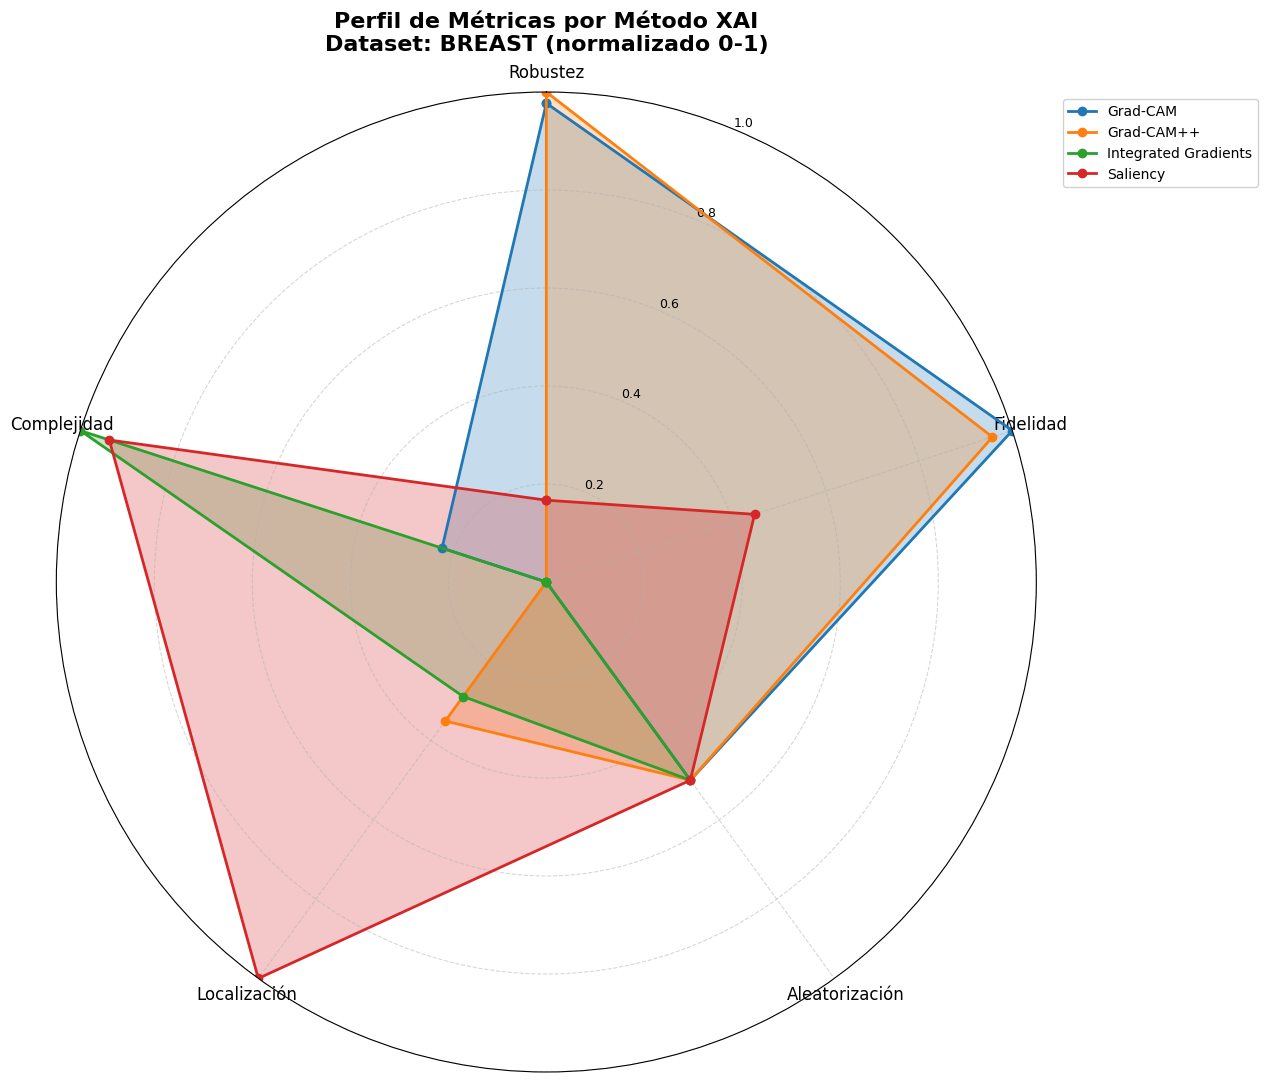

In [42]:
# Generar gráficos radar y mostrar tablas para cada dataset

for ds in datasets:
    plot_radar_for_dataset(ds)

# En este punto se generan las figuras:
# - outputs/quantus_radar_blood.png
# - outputs/quantus_radar_retina.png
# - outputs/quantus_radar_breast.png
# y se muestran en el notebook junto con las tablas de valores originales
# y normalizados que se han utilizado en el Capítulo 4 del TFM.

In [ ]:
# Guardado de tablas (valores originales y normalizados) por dataset

print("\n=== Guardando tablas por dataset en outputs/ ===\n")

for dataset in datasets:
    # Construir tablas
    df_raw = build_df_for_dataset(dataset)

    # Normalización min–max mejorada por dataset (misma lógica que en plot_radar_for_dataset)
    df_norm = df_raw.copy()

    for metric in metric_names:
        col = df_raw[metric].values.astype(float)
        # Filtrar NaN antes de calcular min/max
        valid_col = col[~np.isnan(col)]
        
        if len(valid_col) == 0:
            # Si todos los valores son NaN, asignar 0.5
            df_norm[metric] = 0.5
        else:
            mn, mx = np.nanmin(col), np.nanmax(col)
            
            if mx - mn < 1e-8:
                # Si todos los métodos tienen el mismo valor en esa métrica
                df_norm[metric] = 0.5
            else:
                # Normalización min-max estándar
                df_norm[metric] = (col - mn) / (mx - mn)
                # Reemplazar NaN resultantes con 0
                df_norm[metric] = df_norm[metric].fillna(0.0)

        # Invertimos las métricas donde "menos es mejor"
        if metric in ["robustness", "complexity", "randomization"]:
            df_norm[metric] = 1.0 - df_norm[metric]

    # Rutas de guardado
    raw_path = OUTPUTS_DIR / f"quantus_table_raw_{dataset}.csv"
    norm_path = OUTPUTS_DIR / f"quantus_table_normalized_{dataset}.csv"

    # Guardar tablas
    df_raw.to_csv(raw_path, index=True)
    df_norm.to_csv(norm_path, index=True)

    print(f"📁 Guardado: {raw_path.name}")
    print(f"📁 Guardado: {norm_path.name}")



=== Guardando tablas por dataset en outputs/ ===

📁 Guardado: quantus_table_raw_blood.csv
📁 Guardado: quantus_table_normalized_blood.csv
📁 Guardado: quantus_table_raw_retina.csv
📁 Guardado: quantus_table_normalized_retina.csv
📁 Guardado: quantus_table_raw_breast.csv
📁 Guardado: quantus_table_normalized_breast.csv
